In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from keras import regularizers
from google.colab import files 
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
import pandas as pd
import numpy as np
import os

Followed the step by step from https://www.kaggle.com/general/74235


In [ ]:
! pip install -q kaggle
files.upload() #upload kaggle.json.

## Downloading and extracting the data

In [ ]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d theforcecoder/wind-power-forecasting
!unzip wind-power-forecasting.zip

os.remove('wind-power-forecasting.zip')  

 67% 5.00M/7.51M [00:00<00:00, 14.0MB/s]
100% 7.51M/7.51M [00:00<00:00, 19.0MB/s]
Archive:  wind-power-forecasting.zip
  inflating: Turbine_Data.csv        


In [ ]:
df = pd.read_csv('Turbine_Data.csv', parse_dates = True, header = 0)
df['Time'] = pd.to_datetime(df["Unnamed: 0"], yearfirst = True)

## Visualizing the dataset

No handles with labels found to put in legend.


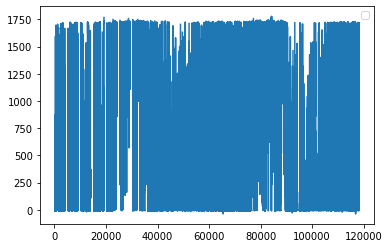

No handles with labels found to put in legend.


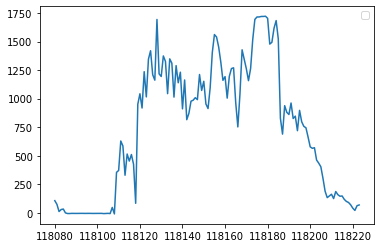

No handles with labels found to put in legend.


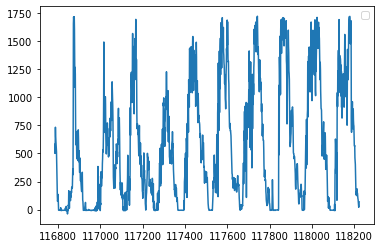

In [ ]:
#Plot ActivePower 
pylab.plot(df["ActivePower"])
pylab.legend()
pylab.show();

#Plot ActivePower. Last 24 hours -   6 * 24
pylab.plot(df["ActivePower"][-144:])
pylab.legend()
pylab.show();

#Plot ActivePower. Last 10 days -  6(m) * 24(h) * 10(d)
pylab.plot(df["ActivePower"][-1440:])
pylab.legend()
pylab.show();

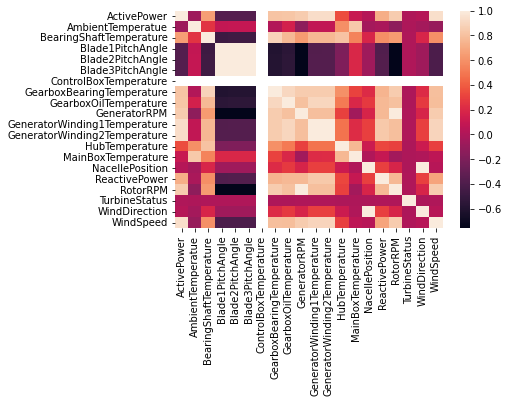

In [ ]:
sns.heatmap(df.corr()); #plot pairise correlation of columns

## Transforming the Data

In [ ]:
df.head()

,Unnamed: 0,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed,Time
0,2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN,2017-12-31 00:00:00+00:00
1,2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN,2017-12-31 00:10:00+00:00
2,2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN,2017-12-31 00:20:00+00:00
3,2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN,2017-12-31 00:30:00+00:00
4,2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN,2017-12-31 00:40:00+00:00


In [ ]:
df.rename(columns={'Unnamed: 0': 'Datetime'}, inplace=True)

In [ ]:
df.Datetime = pd.to_datetime(df.Datetime)

In [ ]:
#Number of missing values in the data set
df.isnull().sum()

Datetime                            0
ActivePower                     23474
AmbientTemperatue               24407
BearingShaftTemperature         55706
Blade1PitchAngle                76228
Blade2PitchAngle                76333
Blade3PitchAngle                76333
ControlBoxTemperature           56064
GearboxBearingTemperature       55684
GearboxOilTemperature           55786
GeneratorRPM                    55929
GeneratorWinding1Temperature    55797
GeneratorWinding2Temperature    55775
HubTemperature                  55818
MainBoxTemperature              55717
NacellePosition                 45946
ReactivePower                   23476
RotorRPM                        56097
TurbineStatus                   55316
WTG                                 0
WindDirection                   45946
WindSpeed                       23629
Time                                0
dtype: int64

In [ ]:
df.corr()['ActivePower'].transpose()

ActivePower                     1.000000
AmbientTemperatue              -0.065637
BearingShaftTemperature         0.655400
Blade1PitchAngle               -0.368997
Blade2PitchAngle               -0.367978
Blade3PitchAngle               -0.367978
ControlBoxTemperature                NaN
GearboxBearingTemperature       0.818850
GearboxOilTemperature           0.821921
GeneratorRPM                    0.849604
GeneratorWinding1Temperature    0.931390
GeneratorWinding2Temperature    0.932521
HubTemperature                  0.347363
MainBoxTemperature              0.101627
NacellePosition                 0.028108
ReactivePower                   0.719092
RotorRPM                        0.849069
TurbineStatus                  -0.000135
WindDirection                   0.028108
WindSpeed                       0.940390
Name: ActivePower, dtype: float64

In [ ]:
# 1: Dropping the rows where the target value is null
df = df.dropna(subset=['ActivePower'])

In [ ]:
# 2: Dropping the features that have a very weak correlation to the target value, considering a threshold of 0.2 (absolute correlation value)
low_corr_features = ['ControlBoxTemperature', 'MainBoxTemperature', 'NacellePosition', 'TurbineStatus', 'WindDirection']
df = df.drop(low_corr_features, axis='columns')

In [ ]:
df.head()

,Datetime,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,ReactivePower,RotorRPM,WTG,WindSpeed,Time
144,2018-01-01 00:00:00+00:00,-5.357727,23.148729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.960830,NaN,G01,2.279088,2018-01-01 00:00:00+00:00
145,2018-01-01 00:10:00+00:00,-5.822360,23.039754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.628441,NaN,G01,2.339343,2018-01-01 00:10:00+00:00
146,2018-01-01 00:20:00+00:00,-5.279409,22.948703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.491235,NaN,G01,2.455610,2018-01-01 00:20:00+00:00
147,2018-01-01 00:30:00+00:00,-4.648054,22.966851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.856136,NaN,G01,2.026754,2018-01-01 00:30:00+00:00
148,2018-01-01 00:40:00+00:00,-4.684632,22.936520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.745593,NaN,G01,1.831420,2018-01-01 00:40:00+00:00


In [ ]:
# 3: Making the Datetime column the index and dropping the time column as it won't be needed
df.index = df['Datetime']
df.drop(['Datetime'], axis='columns', inplace=True)  
df.drop(['Time'], axis='columns', inplace=True)

In [ ]:
# 4: Encoding categorical data
df = pd.get_dummies(df, columns=['WTG'])

In [ ]:
# Number of missing values in the data set
df.isnull().sum()

ActivePower                         0
AmbientTemperatue                1319
BearingShaftTemperature         32739
Blade1PitchAngle                52809
Blade2PitchAngle                52893
Blade3PitchAngle                52893
GearboxBearingTemperature       32722
GearboxOilTemperature           32699
GeneratorRPM                    32814
GeneratorWinding1Temperature    32701
GeneratorWinding2Temperature    32694
HubTemperature                  32860
ReactivePower                      58
RotorRPM                        32947
WindSpeed                         314
WTG_G01                             0
dtype: int64

In [ ]:
# 5: Dropping the remaining null values
df = df.dropna()

In [ ]:
df_processed = df

Splitting into Train, Validation and Test

[ ~ - 28/02/2020 ] -> Train

[01/03/2020 - 15/03/2020 ] -> Validation

[16/03/2020 - ~] -> Test

In [ ]:
mask = (df_processed.index < pd.to_datetime("2020-03-01 00:00:00").tz_localize('US/Eastern'))
training_data = df_processed.loc[mask]

val_mask = (df_processed.index >= pd.to_datetime("2020-03-01").tz_localize('US/Eastern')) & (df_processed.index <= pd.to_datetime("2020-03-15").tz_localize('US/Eastern'))
val_data = df_processed.loc[val_mask]

test_mask = (df_processed.index > pd.to_datetime("2020-03-15").tz_localize('US/Eastern'))
test_data = df_processed.loc[test_mask]

## Data scaling

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [ ]:
training_data.head()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,ReactivePower,RotorRPM,WindSpeed,WTG_G01
Datetime,,,,,,,,,,,,,,,,
2019-05-06 14:10:00+00:00,-7.851491,39.308243,47.154927,45.736893,43.699357,43.699357,58.852307,56.782879,68.210284,62.792258,62.145290,46.003815,-15.007223,0.672715,2.212693,1
2019-05-06 14:20:00+00:00,-8.055341,39.277237,46.936134,33.023277,33.023221,33.023221,57.795437,56.423370,79.658897,62.350706,61.807019,46.003815,-13.566990,0.634549,2.222945,1
2019-05-06 14:30:00+00:00,-5.565284,39.206277,40.058399,41.260297,41.260230,41.260230,48.911180,56.033333,68.229411,61.747975,61.282616,40.253338,-10.851533,0.508198,2.130019,1
2019-05-06 14:40:00+00:00,-5.579984,39.176886,46.615774,35.005263,35.005339,35.005339,56.948740,55.963401,75.046598,61.272020,60.837968,46.003815,-10.302238,0.556917,2.080760,1
2019-05-06 14:50:00+00:00,-5.549332,39.194184,46.500652,39.576077,39.576122,39.576122,56.859428,55.873937,85.012009,60.785716,60.362536,46.003815,-10.303578,0.715614,2.347810,1


In [ ]:
scaler = MinMaxScaler()
transformer = scaler.fit(training_data)

training_data_std = training_data.copy()
training_data_std[training_data_std.columns] = transformer.transform(training_data_std[training_data_std.columns])

test_data_std = test_data.copy()
test_data_std[test_data_std.columns] = transformer.transform(test_data_std[test_data_std.columns])

val_data_std = val_data.copy()
val_data_std[val_data_std.columns] = transformer.transform(val_data_std[val_data_std.columns])

In [ ]:
training_data_std.head()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,ReactivePower,RotorRPM,WindSpeed,WTG_G01
Datetime,,,,,,,,,,,,,,,,
2019-05-06 14:10:00+00:00,0.012032,0.926959,0.855983,0.666867,0.602284,0.602284,0.715635,0.802419,0.037686,0.495312,0.493048,0.958489,0.047598,0.041338,0.056814,0.0
2019-05-06 14:20:00+00:00,0.011919,0.926228,0.852011,0.571491,0.510613,0.510613,0.702783,0.797339,0.044012,0.491829,0.490364,0.958489,0.051223,0.038993,0.057279,0.0
2019-05-06 14:30:00+00:00,0.013296,0.924554,0.727162,0.633284,0.581341,0.581341,0.594752,0.791827,0.037697,0.487075,0.486204,0.838678,0.058058,0.031229,0.053057,0.0
2019-05-06 14:40:00+00:00,0.013288,0.923861,0.846196,0.586360,0.527633,0.527633,0.692487,0.790839,0.041464,0.483321,0.482676,0.958489,0.059441,0.034222,0.050819,0.0
2019-05-06 14:50:00+00:00,0.013305,0.924269,0.844106,0.620650,0.566880,0.566880,0.691401,0.789575,0.046969,0.479485,0.478904,0.958489,0.059438,0.043974,0.062953,0.0


## Sliding window

timeseries_dataset_from_array

 https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array
 
From the documentation:
Creates a dataset of sliding windows over a timeseries provided as array.

In [ ]:
import tensorflow as tf

In [ ]:
batch_size = 32
sequence_length = 24 * 6 # 24 hours

In [ ]:
ds_train = tf.keras.utils.timeseries_dataset_from_array(training_data_std.loc[:, training_data_std.columns != 'ActivePower'], 
                                                        targets=training_data_std['ActivePower'][sequence_length:], 
                                                        sequence_length=sequence_length, 
                                                        batch_size=batch_size)

ds_val = tf.keras.utils.timeseries_dataset_from_array(val_data_std.loc[:, val_data_std.columns != 'ActivePower'], 
                                                      targets=val_data_std['ActivePower'][sequence_length:], 
                                                      sequence_length=sequence_length, 
                                                      batch_size=batch_size)

ds_test = tf.keras.utils.timeseries_dataset_from_array(test_data_std.loc[:, test_data_std.columns != 'ActivePower'], 
                                                       targets=test_data_std['ActivePower'][sequence_length:], 
                                                       sequence_length=sequence_length, 
                                                       batch_size=batch_size)

## Deep Learning model definition

### Model 1: SimpleRNN

In [ ]:
def get_model(learning_rate):
  model = Sequential()

  model.add(SimpleRNN(64, return_sequences=True, input_shape=(sequence_length, len(training_data_std.columns) - 1)))
  model.add(SimpleRNN(32, return_sequences=True))
  model.add(SimpleRNN(16, return_sequences=False))
  model.add(Dense(1, activation='linear'))
  
  model.summary()
  model.compile(loss='mse', optimizer=tf.optimizers.Adam(learning_rate=learning_rate), metrics=['mae', 'mse']) #insert appropriate parameters
  
  return model

In [ ]:
learning_rate = 0.001

In [ ]:
model = get_model(learning_rate)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 144, 64)           5120      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 144, 32)           3104      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 9,025
Trainable params: 9,025
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Using the ModelCheckpoint callback to regularly save checkpoints, and the 
# EarlyStopping callback to interrupt training when the validation loss is 
# not longer improving

patience = 5

path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0,
                                            patience=patience )

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
qt_epochs = 5
hist = model.fit(
    ds_train,
    validation_data=ds_val,
    batch_size=batch_size,
    epochs=qt_epochs,
    callbacks=[es_callback, modelckpt_callback]
)

Epoch 1/5
1138/1138 [==============================] - ETA: 0s - loss: 0.0174 - mae: 0.0791 - mse: 0.0174
Epoch 00001: val_loss improved from inf to 0.01211, saving model to model_checkpoint.h5
1138/1138 [==============================] - 589s 516ms/step - loss: 0.0174 - mae: 0.0791 - mse: 0.0174 - val_loss: 0.0121 - val_mae: 0.0637 - val_mse: 0.0121
Epoch 2/5
1138/1138 [==============================] - ETA: 0s - loss: 0.0089 - mae: 0.0637 - mse: 0.0089
Epoch 00002: val_loss improved from 0.01211 to 0.01205, saving model to model_checkpoint.h5
1138/1138 [==============================] - 591s 519ms/step - loss: 0.0089 - mae: 0.0637 - mse: 0.0089 - val_loss: 0.0121 - val_mae: 0.0609 - val_mse: 0.0121
Epoch 3/5
1138/1138 [==============================] - ETA: 0s - loss: 0.0087 - mae: 0.0624 - mse: 0.0087
Epoch 00003: val_loss did not improve from 0.01205
1138/1138 [==============================] - 584s 513ms/step - loss: 0.0087 - mae: 0.0624 - mse: 0.0087 - val_loss: 0.0125 - val_mae:

## Analysing the results

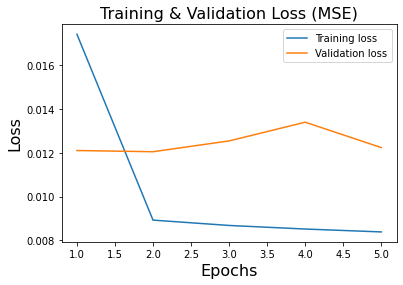

In [ ]:
history_dict = hist.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

# Plot the Loss vs Epochs
plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Training & Validation Loss (MSE)', fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend();

In [ ]:
# Forecasted vs true target values

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

pred = model.predict(ds_test)

inv_pred = np.concatenate((pred, test_data_std.loc[:, test_data_std.columns != 'ActivePower'][sequence_length:]), axis=1)
inv_pred = transformer.inverse_transform(inv_pred)[:, 0]

inv_gt = test_data['ActivePower'][sequence_length:]

rmse = np.sqrt(mean_squared_error(inv_gt, inv_pred))
print('Test RMSE: %.3f' % rmse)

mse = mean_squared_error(inv_gt, inv_pred)
print('Test MSE: %.3f' % mse)

mae = mean_absolute_error(inv_gt, inv_pred)
print('Test MAE: %.3f' % mae)

Test RMSE: 255.224
Test MSE: 65139.258
Test MAE: 150.618


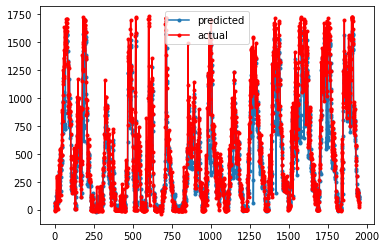

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.arange(0, inv_pred.shape[0]), inv_pred, marker='.', label='predicted')
plt.plot(np.arange(0, inv_gt.shape[0]), inv_gt, marker='.', color='r', label='actual')
plt.legend();

### Model 2: LSTM

In [ ]:
def get_model(learning_rate):
  model = Sequential()

  model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, len(training_data_std.columns) - 1)))
  model.add(LSTM(32, return_sequences=True))
  model.add(LSTM(16, return_sequences=False))
  model.add(Dense(1, activation='linear'))
  
  model.summary()
  model.compile(loss='mse', optimizer=tf.optimizers.Adam(learning_rate=learning_rate), metrics=['mae', 'mse']) #insert appropriate parameters
  
  return model

In [ ]:
model = get_model(learning_rate)

In [ ]:
qt_epochs = 5
hist = model.fit(
    ds_train,
    validation_data=ds_val,
    batch_size=batch_size,
    epochs=qt_epochs,
    callbacks=[es_callback, modelckpt_callback]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 144, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 144, 32)           12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 36,049
Trainable params: 36,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1138/1138 [==============================] - ETA: 0s - loss: 0.0440 - mae: 0.1483 - mse: 0.0440
Epoch 00001: val_loss did not improve from 0.01205
1138/1138 [==============

## Analysing the results

In [ ]:
pred = model.predict(ds_test)

inv_pred = np.concatenate((pred, test_data_std.loc[:, test_data_std.columns != 'ActivePower'][sequence_length:]), axis=1)
inv_pred = transformer.inverse_transform(inv_pred)[:, 0]

inv_gt = test_data['ActivePower'][sequence_length:]

rmse = np.sqrt(mean_squared_error(inv_gt, inv_pred))
print('Test RMSE: %.3f' % rmse)

mse = mean_squared_error(inv_gt, inv_pred)
print('Test MSE: %.3f' % mse)

mae = mean_absolute_error(inv_gt, inv_pred)
print('Test MAE: %.3f' % mae)

Test RMSE: 237.084
Test MSE: 56208.932
Test MAE: 144.048


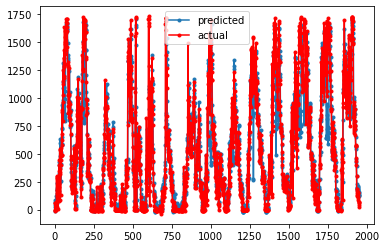

In [ ]:
plt.plot(np.arange(0, inv_pred.shape[0]), inv_pred, marker='.', label='predicted')
plt.plot(np.arange(0, inv_gt.shape[0]), inv_gt, marker='.', color='r', label='actual')
plt.legend();